In [1]:
# prompt: connect to the "soil type" folder in my google drive

from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [2]:
!pip install d2l==1.0.3

In [1]:
import torch
import numpy as np
import torchvision.transforms.v2 as transforms
import torch, torchvision, os
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
#from d2l import torch as d2l
import matplotlib.pyplot as plt

C:\Users\justi\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\justi\anaconda3\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warnin

In [2]:
%cd /content/drive/My\ Drive
%cd Soil_Data/
%cd Soil\ Types
!ls

[WinError 3] The system cannot find the path specified: '/content/drive/My\\ Drive'
C:\Users\justi\Desktop\Learning\JCU\MA5852 - Master Class 2\Assessments\Assessment 3 - CNN for Classification
[WinError 2] The system cannot find the file specified: 'Soil_Data/'
C:\Users\justi\Desktop\Learning\JCU\MA5852 - Master Class 2\Assessments\Assessment 3 - CNN for Classification
[WinError 3] The system cannot find the path specified: 'Soil\\ Types'
C:\Users\justi\Desktop\Learning\JCU\MA5852 - Master Class 2\Assessments\Assessment 3 - CNN for Classification


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
Soil_Image_Path = '/content/drive/"My Drive"/Soil_data/"Soil Types"'
!ls {Soil_Image_Path}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [48]:
# Define transformation that you wish to apply on image
data_transforms = transforms.Compose([
                    transforms.CenterCrop(255),
                    transforms.ToTensor(),
                    transforms.ConvertImageDtype(torch.float32)])

# Other transforms:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

# Load the datasets with ImageFolder
image_datasets = torchvision.datasets.ImageFolder(root= "/content/drive/My Drive/Soil_data/Soil Types", transform=data_transforms)

#Using the image datasets and the transforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=32, shuffle=True, num_workers=1)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [53]:
# Indexing the image_dataset
image1, label = image_datasets[100]
print(label)

4


In [30]:
torch.Tensor.size(image1)

torch.Size([3, 32, 32])

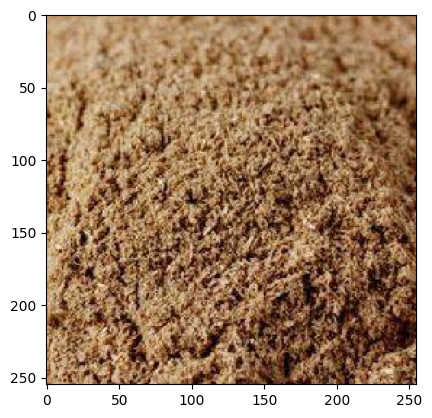

In [54]:
#Plotting an image
img = image1.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.show()


In [32]:
# Define relevant variables for the ML task
batch_size = 32
num_classes = 5
learning_rate = 0.001
num_epochs = 1

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
# Helper function: to assist with the number of features in an input layer resulting from a 2dcov
#"""
#Utility function for computing output of convolutions
#takes a tuple of (h,w) and returns a tuple of (h,w)
#"""
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

In [60]:
N_pixel = 256
in_tup = (N_pixel,N_pixel)
out_tup = conv_output_shape(in_tup,3,1,0,1)
out2_tup = conv_output_shape(out_tup,3,1,0,1)

print('This is the tensor size from two Conv2D applications: ',out2_tup)
print('Now, max_pool2d(i,i) will reduce the dimensions by 1/i')
print('So if i = 2, and there are two Conv2D and 2 max_pool2d, the reultant feature size will be 62x62')

This is the tensor size from two Conv2D applications:  (252, 252)
Now, max_pool2d(i,i) will reduce the dimensions by 1/i
So if i = 2, and there are two Conv2D and 2 max_pool2d, the reultant feature size will be 62x62


In [56]:
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
                in_channels=3,      # 3 Color Channels (RGB)
                out_channels=6,
                kernel_size=3,
                stride=1
        )
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
     #   self.linear1 = nn.Linear(16*6*6, 120)
        self.linear1 = nn.Linear(16*62*62, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        # Next, flatten the predicted value. Careful with the byte size
        #x = x.view(-1, 16*6*6) # Using '-1', the first dimension is retained as 100
        x = x.view(-1, 16*62*62) # Using '-1', the first dimension is retained as 100
        # Insert some linear layers
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)

        # Softmax
        x = F.log_softmax(x, dim=1)

        return x

In [57]:
model = ConvNet() # Define this for validation purposes
#model_on_gpu = ConvNet().cuda() # Define this to actually train the model on the GPU

print(model)


ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=61504, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [61]:
# Passing through a single image data to validate the model
image1, label = image_datasets[100]
#input = Variable(torch.randn(1, 3, 32, 32))
#out = model(input)
out = model(image1)
print(out)

tensor([[-2.2981, -2.2938, -2.3832, -2.3174, -2.3203, -2.3870, -2.2898, -2.1799,
         -2.3582, -2.2183]], grad_fn=<LogSoftmaxBackward0>)


In [62]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

tensor([[-2.4933, -2.1067, -2.1087, -2.2571, -2.5500, -2.2224, -2.1857, -2.5974,
         -2.4257, -2.2260]], grad_fn=<LogSoftmaxBackward0>)


In [64]:
total_step = len(dataloaders)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloaders):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))